In [26]:
import os.path as op 
import tempfile 
import matplotlib.pyplot as plt 

import hnn_core
from hnn_core import (jones_2009_model, simulate_dipole, MPIBackend, read_dipole, read_params)
from hnn_core.viz import plot_dipole
from hnn_core import JoblibBackend
from hnn_core import read_spikes
hnn_core_root = op.join(op.dirname(hnn_core.__file__))
from hnn_core.optimization import optimize_evoked

import numpy as np 

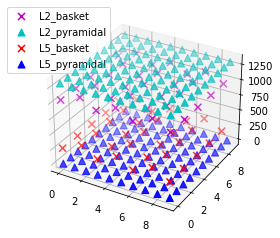

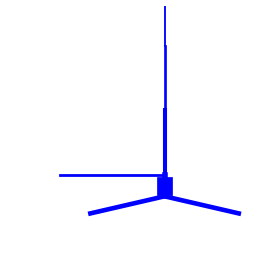

<Axes3DSubplot: >

In [4]:
#default network 
net = jones_2009_model()
net.plot_cells()
net.cell_types['L5_pyramidal'].plot_morphology()

In [2]:
##number of cores 
n_procs = 10 

In [56]:
#load in inverso data 
data = np.loadtxt('/Users/elizabethkaplan/Desktop/V1_Modeling/V1_HNN_Modeling/Inverso_HBM_2016_Waveform_Figs/Inverso_Data_New.txt')
#print(data)
Inverso_data_formatted = np.array(data)
#print(data_formatted)
#save formatted file locally
#Inverso_data_formatted.to_csv('/Users/elizabethkaplan/Desktop/V1_Modeling/V1_HNN_Modeling/Inverso_data_formatted.txt', sep='\t', index=False)

output_file = '/Users/elizabethkaplan/Desktop/V1_Modeling/V1_HNN_Modeling/Inverso_data_formatted.txt'
np.savetxt(output_file, Inverso_data_formatted, delimiter='\t')
exp_dpl = read_dipole(output_file)

#exp_dpl = read_dipole(data_formatted)

/Users/elizabethkaplan/hnn-core/hnn_core/dipole.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  self.sfreq = 1000. / (times[1] - times[0])  # NB assumes len > 1


In [6]:
#My Simulation params - inverso_upper.param (Pre Optimization)
# Distal Drive 
weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': 0.000007,
                   'L5_pyramidal': 0.1423}
weights_nmda_d1 = {'L2_basket': 0.059482, 'L2_pyramidal': 0.999317,
                   'L5_pyramidal': 0.090074}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
net.add_evoked_drive(
    'evdist1', mu=69.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal',
    synaptic_delays=synaptic_delays_d1, event_seed=274)

#Proximal Drives  
weights_ampa_p1 = {'L2_basket': 0.157106, 'L2_pyramidal': 0.015912,
                   'L5_basket': 0.351963, 'L5_pyramidal': 0.008033}
synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                        'L5_basket': 1., 'L5_pyramidal': 1.}
# all NMDA weights are zero; pass 0's explicitly for later optimization 
weights_nmda_p1 = {'L2_basket': 0.0, 'L2_pyramidal': 0.0,
                   'L5_basket': 0.0, 'L5_pyramidal': 0.0} 

net.add_evoked_drive(
    'evprox1', mu=46.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=544)

# Second proximal evoked drive. NB: only AMPA weights differ from first
weights_ampa_p2 = {'L2_basket': 0.000002, 'L2_pyramidal': 1.893286,
                   'L5_basket': 0.007079, 'L5_pyramidal': 0.378367}
weights_nmda_p2 = {'L2_basket': 0.227243, 'L2_pyramidal': 0.069407,
                   'L5_basket': 0.656751, 'L5_pyramidal': 0.006741}
# all NMDA weights are zero; omit weights_nmda (defaults to None)
net.add_evoked_drive(
    'evprox2', mu=142.082563, sigma=11.160701, numspikes=1,
    weights_ampa=weights_ampa_p2, weights_nmda=weights_nmda_p2,location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=814)

In [48]:
#simulate dipole with params defined above - NEW
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    init_dpl = simulate_dipole(net, tstop=300, n_trials=1)[0]
#below params (scale&smooth) are from earlier work on GUI
init_dpl.scale(10) #set scale factor to 10
init_dpl.smooth(30) #set smooth window length to 30 

MPIBackend is set to use 1 core: tranferring the simulation to JoblibBackend....
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...


In [7]:
#simulate dipole with params defined above - OLD
#joblib allows jobs to run in parallel 
#with JoblibBackend(n_jobs=1):
#    dpls = simulate_dipole(net, tstop=170., record_vsec='soma')

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/elizabethkaplan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


In [8]:
# Cell IDs (gids) uniquely define neurons in the network 
gid_ranges = net.gid_ranges
print(net.gid_ranges)

{'L2_basket': range(0, 35), 'L2_pyramidal': range(35, 135), 'L5_basket': range(135, 170), 'L5_pyramidal': range(170, 270), 'evdist1': range(270, 540), 'evprox1': range(540, 810), 'evprox2': range(810, 1080)}


In [9]:
#CellResponse object stores data produced by individual cells, including spikes, voltages, and currents 
trial_idx = 0
vsec = net.cell_response.vsec[trial_idx]
print(vsec.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

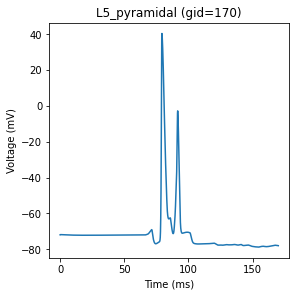

In [10]:
#plot firing pattern of individual cells 
gid = 170
plt.figure(figsize=(4, 4), constrained_layout=True)
plt.plot(net.cell_response.times, vsec[gid]['soma'])
plt.title('%s (gid=%d)' % (net.gid_to_type(gid), gid))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()

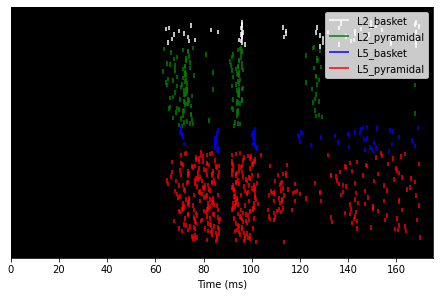

Writing file /var/folders/s6/21s_2dfj2f195fl1lglp7jrw0000gn/T/tmplx95fgnt/spk_0.txt


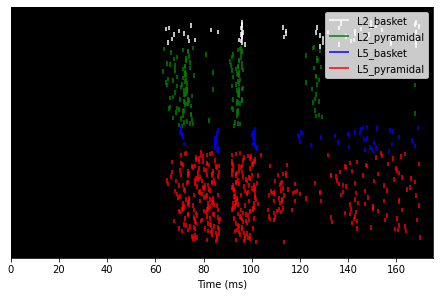

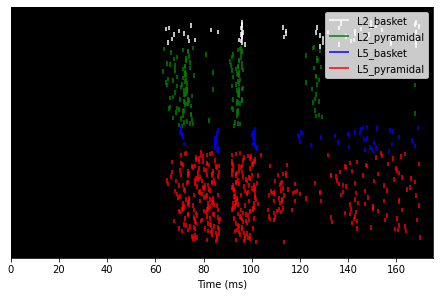

In [11]:
#plot the spikes in the network and write them to txt files 
net.cell_response.plot_spikes_raster()
with tempfile.TemporaryDirectory() as tmp_dir_name:
    net.cell_response.write(op.join(tmp_dir_name, 'spk_%d.txt'))
    cell_response = read_spikes(op.join(tmp_dir_name, 'spk_*.txt'))
cell_response.plot_spikes_raster()

In [12]:
#calculate mean spike rates for each cell class 
all_rates = cell_response.mean_rates(tstart=0, tstop=170,
                                     gid_ranges=net.gid_ranges,
                                     mean_type='all')
trial_rates = cell_response.mean_rates(tstart=0, tstop=170,
                                       gid_ranges=net.gid_ranges,
                                       mean_type='trial')
print('Mean spike rates across trials:')
print(all_rates)
print('Mean spike rates for individual trials:')
print(trial_rates)

Mean spike rates across trials:
{'L2_basket': 10.756302521008404, 'L2_pyramidal': 9.64705882352941, 'L5_basket': 11.092436974789916, 'L5_pyramidal': 24.29411764705883}
Mean spike rates for individual trials:
{'L2_basket': [10.756302521008404], 'L2_pyramidal': [9.64705882352941], 'L5_basket': [11.092436974789916], 'L5_pyramidal': [24.29411764705883]}


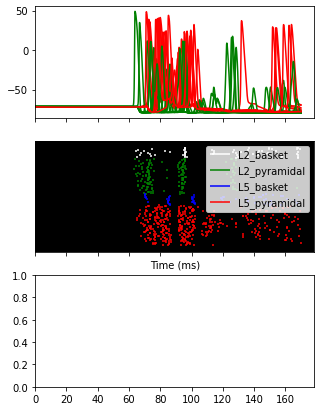

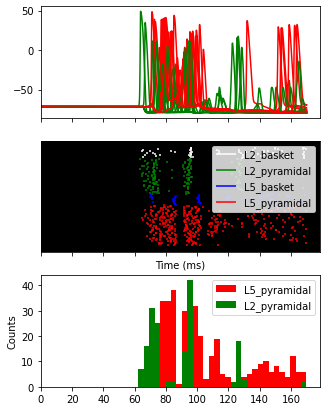

In [13]:
#plot soma voltage along with spiking activity
fig, axes = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

for idx in range(10):  # only 10 cells per cell-type
    gid = gid_ranges['L2_pyramidal'][idx]
    axes[0].plot(net.cell_response.times, vsec[gid]['soma'], color='g')
    gid = gid_ranges['L5_pyramidal'][idx]
    axes[0].plot(net.cell_response.times, vsec[gid]['soma'], color='r')
net.cell_response.plot_spikes_raster(ax=axes[1])
net.cell_response.plot_spikes_hist(ax=axes[2],
                                   spike_types=['L5_pyramidal',
                                                'L2_pyramidal'])

In [14]:
#smoothing and scaling 
window_len, scaling_factor = 30, 3000
for dpl in dpls:
    dpl.smooth(window_len).scale(scaling_factor)

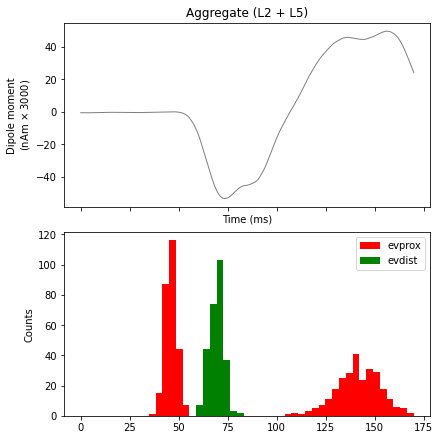

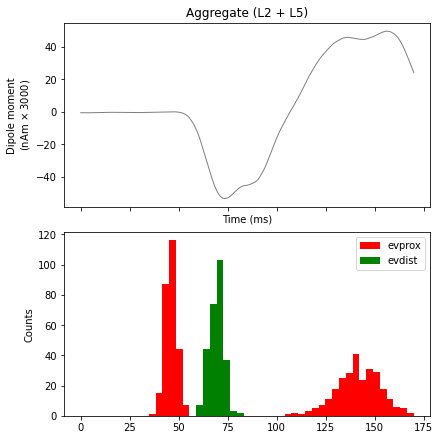

In [15]:
#plt simulated aggregated dipole moments over time 
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)
plot_dipole(dpls, ax=axes[0], layer='agg', show=False)
net.cell_response.plot_spikes_hist(ax=axes[1], spike_types=['evprox', 'evdist'])

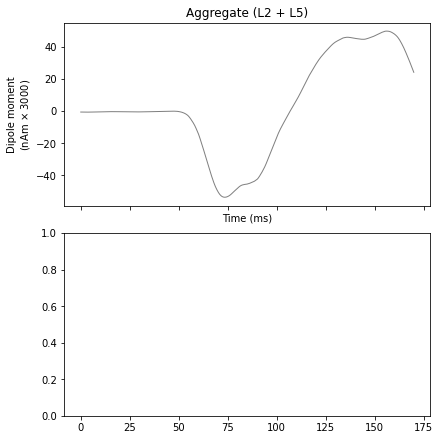

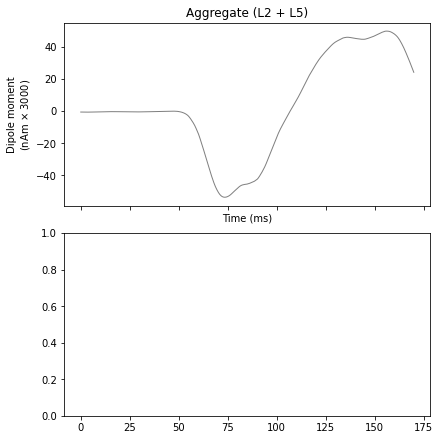

In [22]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)
plot_dipole(dpls, ax=axes[0], layer='agg', show=False)

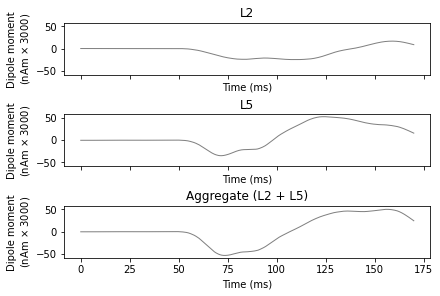

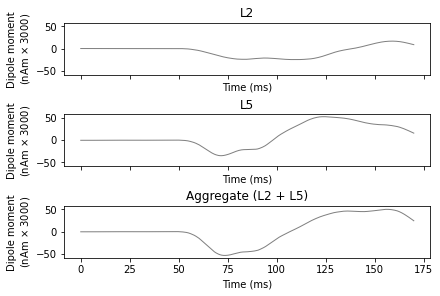

In [16]:
#visualize layer contributions seperately 
plot_dipole(dpls, average=False, layer=['L2', 'L5', 'agg'], show=False)

In [ ]:
#simulate the network 
trial_idx = 0
dpls[trial_idx].copy().smooth(window_len).scale(scaling_factor).plot()
net.cell_response.plot_spikes_hist()

In [17]:
##OPTIMIZATION
#from https://jonescompneurolab.github.io/hnn-core/stable/auto_examples/howto/optimize_evoked.html#sphx-glr-auto-examples-howto-optimize-evoked-py 
#function for optimization. takes in network with no attached drives & defines parameters we will optimize
def set_params(net, params):

    # Proximal 1
    net.add_evoked_drive('evprox1',
                         mu=5.6813,
                         sigma=20.3969,
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p1,
                         weights_nmda=weights_nmda_p1,
                         synaptic_delays=synaptic_delays_p)

    # Distal
    net.add_evoked_drive('evdist1',
                         mu=58.6539,
                         sigma=5.5810,
                         numspikes=1,
                         location='distal',
                         weights_ampa=weights_ampa_d1,
                         weights_nmda=weights_nmda_d1,
                         synaptic_delays=synaptic_delays_d1)

    # Proximal 2
    weights_ampa_p2 = {'L2_basket':
                       params['evprox2_ampa_L2_basket'],
                       'L2_pyramidal':
                       params['evprox2_ampa_L2_pyramidal'],
                       'L5_basket':
                       params['evprox2_ampa_L5_basket'],
                       'L5_pyramidal':
                       params['evprox2_ampa_L5_pyramidal']}
    weights_nmda_p2 = {'L2_basket':
                       params['evprox2_nmda_L2_basket'],
                       'L2_pyramidal':
                       params['evprox2_nmda_L2_pyramidal'],
                       'L5_basket':
                       params['evprox2_nmda_L5_basket'],
                       'L5_pyramidal':
                       params['evprox2_nmda_L5_pyramidal']}
    net.add_evoked_drive('evprox2',
                         mu=params['evprox2_mu'],
                         sigma=params['evprox2_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p2,
                         weights_nmda=weights_nmda_p2,
                         synaptic_delays=synaptic_delays_p)
    
#predefined constraints based on physiological realism
constraints = dict({'evprox2_ampa_L2_basket': (0.01, 1.),
                    'evprox2_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox2_ampa_L5_basket': (0.01, 1.),
                    'evprox2_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L2_basket': (0.01, 1.),
                    'evprox2_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L5_basket': (0.01, 1.),
                    'evprox2_nmda_L5_pyramidal': (0.01, 1.),
                    'evprox2_mu': (100., 120.),
                    'evprox2_sigma': (2., 30.)})


In [21]:
optimize_evoked

<function hnn_core.optimization.optimize_evoked(net, tstop, n_trials, target_dpl, initial_dpl, maxiter=50, timing_range_multiplier=3.0, sigma_range_multiplier=50.0, synweight_range_multiplier=500.0, decay_multiplier=1.6, scale_factor=1.0, smooth_window_len=None, dt=0.025, which_drives='all')>

In [24]:
optim_test = optimize_evoked(net, tstop=170, n_trials=10, target_dpl=data, initial_dpl=dpls)

AttributeError: 'numpy.ndarray' object has no attribute 'times'

In [ ]:
#define and fit optimizer
optim = optimize_evoked(net, tstop=170, target_dpl=data, initial_dpl=)

with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    optim.fit(target=exp_dpl, scale_factor=scale_factor,
              smooth_window_len=smooth_window_len)

In [35]:
##Read in existing param file - created on GUI 
params_fname = op.join('/Users/elizabethkaplan/hnn_out/data/inverso_uppe_optimize/before_opt.param')
pre_optimization_params = read_params(params_fname)
print(params)

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619